In [1]:
#packages
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, plot_roc_curve, average_precision_score

import pickle

import seaborn as sns 
import matplotlib.pyplot as plt

import shap

### Import Data

In [2]:
data=pd.read_pickle('data/feature_eng__df.pickle')

### Train Test

In [3]:
#xg and outcome are not features
X=data.drop(['xg', 'outcome'], axis=1) 
y_xg=data[['xg', 'outcome']] 

#train test split
X_train, X_test, y_train_xg, y_test_xg = train_test_split(X, y_xg, test_size=0.20, random_state=42) 

#split outcome and xg
y_train=y_train_xg['outcome']
y_train_xg=y_train_xg['xg']

y_test=y_test_xg['outcome']
y_test_xg=y_test_xg['xg']

### Pipeline

9 features are used :
   - distance : distance between shooting point and the middle of the goal line
   - angle : shooting angle
   - nb_players : Number of players in the shooting angle (offensives and defensives)
   - under_pressure : player under pressure during the shot
   - first_time : the player touches the ball for the first time when he shoots 
   - open_goal : no one to keep the goal
   - technique : Lob, volley, head, etc..
   - body_part : Foot, Head, Other
   - type : Open-Play, penalty, Free kick

In [4]:
num_features = ['distance', 'angle', 'nb_players']

cat_features = ['under_pressure', 'first_time', 'open_goal', 
                        'technique', 'body_part', 'type']

num_transformer=Pipeline(steps=[('scaler', StandardScaler())])

cat_transformer=Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num_1', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

param_grid = {
    'classifier__nthread': [4],
    'classifier__objective': ['binary:logistic'],
    'classifier__max_depth': [3],
    'classifier__learning_rate': [0.1, 0.15],
    'classifier__n_estimators': [50, 100],
    'classifier__seed': [42]
}

cv = KFold(n_splits=5)

#model is refitted according to ROC AUC
grid= GridSearchCV(model, param_grid, cv=cv, n_jobs= -1, 
                     return_train_score=True, refit=True, 
                     scoring='roc_auc', verbose=2)

In [5]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   21.6s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_1',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['distance',
                                                                          'angle',
                                                                          'nb_players']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                 

In [6]:
#cv results to check under/over-fitting
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__nthread,param_classifier__objective,param_classifier__seed,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.012905,0.439347,0.031103,0.008349,0.1,3,50,4,binary:logistic,42,...,0.800302,0.020382,4,0.824455,0.829460,0.822979,0.815122,0.830827,0.824569,0.005565
1,4.978000,1.164054,0.029102,0.006710,0.1,3,100,4,binary:logistic,42,...,0.801205,0.022470,2,0.834920,0.840156,0.835128,0.826738,0.843690,0.836126,0.005728
2,1.376300,0.204013,0.025199,0.005287,0.15,3,50,4,binary:logistic,42,...,0.801682,0.021451,1,0.831721,0.836165,0.828553,0.822754,0.837545,0.831347,0.005355
3,2.547000,0.949335,0.021400,0.002957,0.15,3,100,4,binary:logistic,42,...,0.800383,0.022765,3,0.843136,0.849033,0.842492,0.838472,0.853734,0.845373,0.005371


In [7]:
#prediction
y_pred=grid.predict(X_test)
y_pred_score=grid.predict_proba(X_test)

In [8]:
tn, fp, fn, tp=confusion_matrix(y_test, y_pred).ravel() 
print('True positive rate (arbitrary threshold 0.5): ', tp/(tp+fn))

#compare my model and statsbomb model
print('auc modele : ', roc_auc_score(y_test, y_pred_score[:,1]))
print('auc statsbomb : ', roc_auc_score(y_test, y_test_xg))

True positive rate (arbitrary threshold 0.5):  0.22916666666666666
auc modele :  0.8187299410359754
auc statsbomb :  0.8327377842464049


Comparaison des 2 distributions

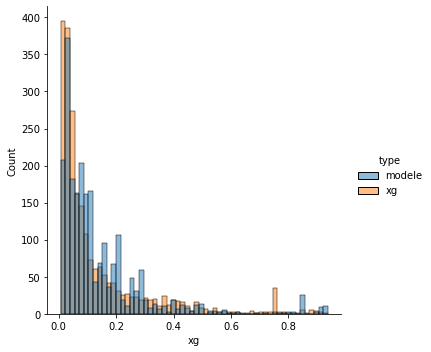

In [9]:
#2 distributions : model output and statsbomb Xg
modele_df=pd.DataFrame(y_pred_score[:,1], columns=['xg'])
modele_df['type']='modele'

xg_df=pd.DataFrame(y_test_xg, columns=['xg'])
xg_df['type']='xg'

compar_df=pd.concat([modele_df, xg_df], axis=0) 

sns.displot(data=compar_df, x='xg', hue='type')

Calibration Curve

In [10]:
#calibration curve
def calibrationCurve(y_test, y_test_score, title):
    
    from sklearn.calibration import calibration_curve
    
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_score, n_bins=9)

    fig, ax = plt.subplots(1, figsize=(12, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, 's-')
    plt.plot([0, 1], [0, 1], '--', color='gray')

    sns.despine(left=True, bottom=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.title("Calibration Curve {}".format(title), fontsize=20)
    plt.show()
    

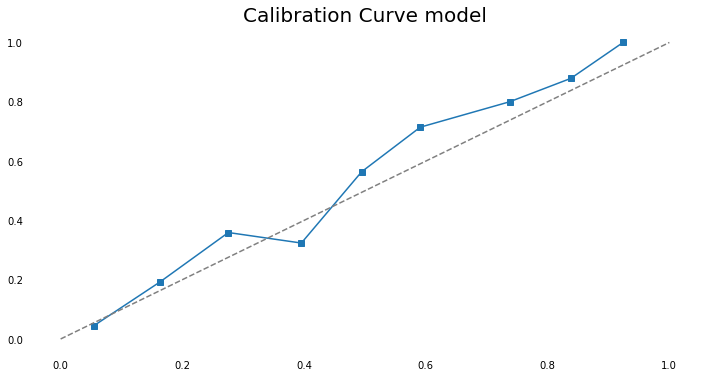

In [11]:
calibrationCurve(y_test, y_pred_score[:,1], 'model')

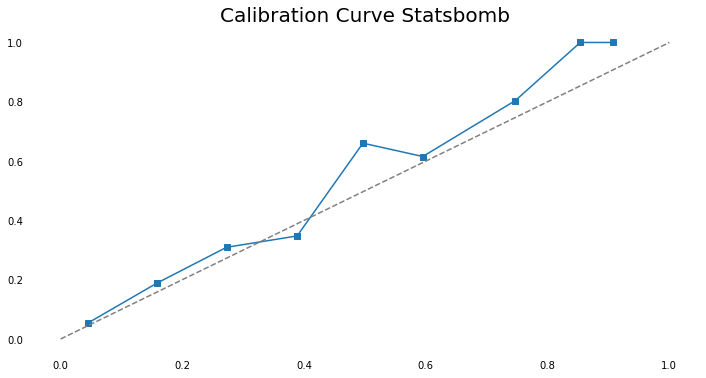

In [12]:
calibrationCurve(y_test, y_test_xg, 'Statsbomb')

In [13]:
#export model
path='APP_dash/data/model_xgb.pickle'
pickle.dump(grid, open(path, 'wb'))

In [14]:
#export X test
X_test.to_csv('APP_dash/data/X_test.csv')